# Simple Image Classifier

Beginner-friendly image classifier built with [PyTorch](https://pytorch.org) and CIFAR-10.

<img alt="A photo of a man on an elephant with an ML-generated overlay showing objects in the frame" src="../assets/preview.png" width=450px>

An image classifier is an ML model that recognizes objects in images. We can build image classifiers by feeding tens of thousands of labelled images to a neural network. Tools like PyTorch train these networks by evaluating their performance against the dataset.

Let's build an image classifier that detects planes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We'll download a dataset, configure a neural network, train a model, and evaluate its performance.

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with [`torchvision`](https://pytorch.org/vision/stable/datasets.html) and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified
car


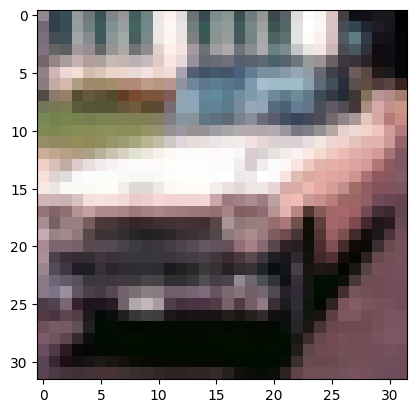

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download training data from open datasets.
training_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Download testing data from open datasets.
testing_data = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

# Hyper parameters
batch_size = 10
EPOCHS = 10
learning_rate = 0.001

# Create data loaders.
train_dataloader = torch.utils.data.DataLoader(
    training_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=2
    )
test_dataloader = torch.utils.data.DataLoader(
    testing_data,
    shuffle=True,
    batch_size=batch_size,
    num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
load_data_itr = iter(train_dataloader)
imgs, lables = load_data_itr.next()

print(classes[lables[0]])
plt.imshow(np.transpose(imgs[0], (1, 2, 0)))
plt.show()

## Step 2:Creating Models
Now that we have our dataset, we need to set up a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) for PyTorch. Our neural network will transform an image into a description.

To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function.



In [2]:
print(torch.cuda.is_available())

False


In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Get cpu or gpu device for training.
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.input_lay = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.headen1_lay = nn.Linear(in_features=120, out_features=84)
        self.output_lay = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.input_lay(x))
        x = F.relu(self.headen1_lay(x))
        x = self.output_lay(x)
        return x
net = Net()


# Define a loss function and optimizer
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# optimizer = optim.Adam(net.parameters(), lr=learning_rate)                    # things to try

print("Your network is ready for training!")

Using cpu device
Your network is ready for training!


In [4]:
for param in net.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([6, 3, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([6])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 6, 5, 5])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([120, 400])
<class 'torch.nn.parameter.Parameter'> torch.Size([120])
<class 'torch.nn.parameter.Parameter'> torch.Size([84, 120])
<class 'torch.nn.parameter.Parameter'> torch.Size([84])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 84])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [5]:
from tqdm import tqdm

print("Training...")
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fun(outputs, labels)
        loss.backward()
        optimizer.step()

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 10 of 10: 100%|██████████████████████| 5000/5000 [00:22<00:00, 220.75it/s]


# Step 4: Test the trained model

Let's test our model!

tensor([4, 0, 5, 2, 1, 2, 8, 8, 8, 8])


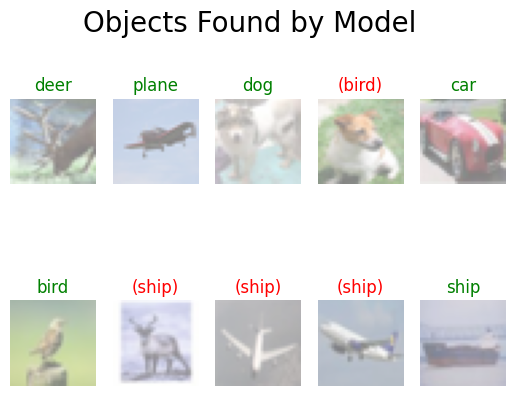

In [6]:
# Pick random photos from training set
if load_data_itr == None:
    load_data_itr = iter(test_dataloader)
images, labels = load_data_itr.next()

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)
# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [7]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
tot_accuracy = 0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    tot_accuracy+=accuracy
print(f"total accuracy is {tot_accuracy/10}%")

Accuracy for class: plane is 57.1 %
Accuracy for class: car   is 67.0 %
Accuracy for class: bird  is 53.2 %
Accuracy for class: cat   is 37.6 %
Accuracy for class: deer  is 48.7 %
Accuracy for class: dog   is 42.2 %
Accuracy for class: frog  is 72.5 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 71.3 %
Accuracy for class: truck is 72.4 %
total accuracy is 58.6%
